<a href="https://colab.research.google.com/github/jiulong15/comp90051/blob/main/HF_patient(ICU_readmission).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [111]:
# Import libraries
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# authenticate
auth.authenticate_user()


project_id = 'ordinal-ember-431323-p0'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
dataset = 'mimiciv'

# Define of problem statment and patient corhot



**Problem Statment**: Build a classification model to predict whether ICU patients diagnosed with heart failure will be readmitted into ICU within the same hospitalization stay.

**Problem Significance**: Previous studies have shows that ICU readmission patients have higher mortality rate, Length of stay and increase of resources utilization which is direct correlated to patients' poor outcomes (Ponzoni, C.R et al 2017). Other study have show that Heart failure(HF) is one of the most risky and resource intensive disease in ICU due to its complex states (Metkus, T.S et al 2021.). Therefore, we want to build a patient cohrot to focus on studying ICU patients who have Heart Failure to explore any potential correlated features that will cause HF patients readmissted into ICU during the same hospitalization stay. This project aims to identify HF patients who have risk of ICU reamission so that an early personlized intervention plans can be implemented after those patients discharge from the ICU at the first time to ultimately imprving patients'| outcomes.

**Patient Cohort**: ICU patients who have dignosis as Heart Failure.

**Define of Heart Failure Patient**: According to the paper, "Identifying Heart Failure using EMR-based algorithms", patients who have NT-proBNP test result that higher than 450 pg/ML and taking Heart Failure medications can indiciate illness of Heart Failure.(Tison,G.H et al, 2018)

**Definition of ICU readmission**: Readmission was defined as admission to ICU of a patient who had been previously admitted to the ICU during the same hospitalization stay (Ponzoni, C.R et al 2017)

**Definition of Non-ICU readmission**: Non-ICU readmission patients is been definied as a patients who had only admiitted into the ICU once during the same hospitalization stay and discharg from the hospital alive without death records.



## Identify readmission patient and non-readmission patient

### query all unique hospital admission along with ICU

In [112]:
# Total number of unique Hadm_id
query= f'''
SELECT distinct(hadm_id)
FROM
    `physionet-data.mimiciv_hosp.admissions`
GROUP BY hadm_id
'''

admission_count= run_query(query)
print(admission_count.shape)

(431231, 1)


In [113]:
# Total umber of unique Hadm_id that have ICU admission records
query= f'''
SELECT DISTINCT (hadm_id)
FROM
    `physionet-data.mimiciv_icu.icustays`
ORDER BY
  hadm_id
'''
admission_count= run_query(query)
print(admission_count.shape)

(66239, 1)


The result shows that there are totally 431231 unique hospitalization stay in the mimic-iv. Within this group, there are 15.3% of patients have admitted into icu at leat once

### Label the readmission records


**Definition:** readmission records are identitied as patients who admitted into the ICU more than once during the same hospitlization.

In [171]:
# Obtain all ICU admission records
query= f'''
SELECT subject_id,hadm_id, stay_id,outtime

FROM
    `physionet-data.mimiciv_icu.icustays`

ORDER BY
  subject_id, hadm_id, outtime

'''

ICU_admission= run_query(query)
print(ICU_admission.head())

   subject_id   hadm_id   stay_id             outtime
0    10000032  29079034  39553978 2180-07-23 23:50:47
1    10000980  26913865  39765666 2189-06-27 20:38:27
2    10001217  24597018  37067082 2157-11-21 22:08:00
3    10001217  27703517  34592300 2157-12-20 14:27:41
4    10001725  25563031  31205490 2110-04-12 23:59:56


In [173]:
print(ICU_admission[ICU_admission['stay_id'] == 37153661])

    subject_id   hadm_id   stay_id             outtime
73    10011365  26712576  37153661 2166-02-20 08:54:53


In [115]:
# Count ICU stay for each unique hospitalization records
query= f'''
SELECT
    subject_id,hadm_id, count(stay_id) as icu_admission

FROM
    `physionet-data.mimiciv_icu.icustays`
GROUP BY subject_id, hadm_id
ORDER BY subject_id, hadm_id
'''
count_icuStay= run_query(query)
print(count_icuStay.shape)
count_icuStay.head()

(66239, 3)


,subject_id,hadm_id,icu_admission
0,10000032,29079034,1
1,10000980,26913865,1
2,10001217,24597018,1
3,10001217,27703517,1
4,10001725,25563031,1


In [144]:
# create a dataframe that only have readmission patient
readmission = count_icuStay[count_icuStay['icu_admission'] > 1]
readmission = readmission.drop(columns=['icu_admission'])

# Using merge to fill in the stay_id info
readmission = pd.merge(readmission, ICU_admission, on=['subject_id','hadm_id'], how='inner')

# only keep the earlist stay id for each hadm_id
readmission.sort_values(by=['subject_id', 'hadm_id','outtime'])
readmission = readmission.groupby(['subject_id','hadm_id']).first().reset_index()
readmission['readmission_status'] = '1'
readmission = readmission[['subject_id','hadm_id','stay_id','readmission_status']]
print(readmission.shape)
readmission.head()



(5820, 4)


,subject_id,hadm_id,stay_id,readmission_status
0,10002428,28662225,33987268,1
1,10003400,23559586,34577403,1
2,10006053,22942076,32895909,1
3,10013569,27993048,38857852,1
4,10014354,27487226,34600477,1


### Identify ICU admission with death records

Non-readmission records: non-readmission records are identified by patients who only admitted into ICU once and dischare healthly without death records

In [146]:
# collect death time

query= f'''
SELECT
    subject_id,
    hadm_id,
    deathtime,
    dischtime
FROM
    `physionet-data.mimiciv_hosp.admissions`
WHERE
     deathtime is not null
ORDER BY
  subject_id, hadm_id, deathtime
'''

death_time= run_query(query)


death_time = death_time.drop_duplicates(subset=['subject_id'], keep='last')
print(death_time.shape)
death_time.head()


(8592, 4)


,subject_id,hadm_id,deathtime,dischtime
0,10001884,26184834,2131-01-20 05:15:00,2131-01-20 05:15:00
1,10002155,20345487,2131-03-10 21:53:00,2131-03-10 01:55:00
2,10003400,23559586,2137-09-02 17:05:00,2137-09-02 17:05:00
3,10004401,25777141,2144-06-18 21:30:00,2144-06-18 21:30:00
4,10004720,22081550,2186-11-17 18:30:00,2186-11-17 18:30:00


In [179]:
print(death_time[death_time['hadm_id'] == 28751837])

      subject_id   hadm_id           deathtime           dischtime
8054    19406319  28751837 2173-10-05 13:00:00 2173-10-05 13:00:00


In [148]:
died_patient = death_time[['subject_id','hadm_id']]
died_patient['status'] = 'died'
died_patient.drop_duplicates(subset=['subject_id'], keep='first', inplace=True)
died_patient.head()

,subject_id,hadm_id,status
0,10001884,26184834,died
1,10002155,20345487,died
2,10003400,23559586,died
3,10004401,25777141,died
4,10004720,22081550,died


### Identify non-readmission ICU patients without death records

In [156]:
non_readmission = count_icuStay[count_icuStay['icu_admission'] == 1]
non_readmission = non_readmission.drop(columns=['icu_admission'])

non_readmission = pd.merge(non_readmission, died_patient,
                           on=['subject_id','hadm_id'], how='left')

non_readmission = non_readmission[non_readmission['status'].isnull()]

non_readmission['readmission_status'] = '0'

non_readmission = pd.merge(non_readmission, ICU_admission, on=['subject_id','hadm_id'], how='left')

non_readmission = non_readmission.sort_values(by=['subject_id', 'hadm_id','outtime'])
non_readmission = non_readmission.groupby(['subject_id','hadm_id']).first().reset_index()
non_readmission = non_readmission[['subject_id','hadm_id','stay_id','readmission_status']]

print(non_readmission.shape)
non_readmission.head()


(54517, 4)


,subject_id,hadm_id,stay_id,readmission_status
0,10000032,29079034,39553978,0
1,10000980,26913865,39765666,0
2,10001217,24597018,37067082,0
3,10001217,27703517,34592300,0
4,10001725,25563031,31205490,0


### Overall, the label for ICUn readmission and non-ICU readmission

In [157]:
readmission_status = pd.concat([readmission, non_readmission])
print(readmission_status.shape)
readmission_status

(60337, 4)


,subject_id,hadm_id,stay_id,readmission_status
0,10002428,28662225,33987268,1
1,10003400,23559586,34577403,1
2,10006053,22942076,32895909,1
3,10013569,27993048,38857852,1
4,10014354,27487226,34600477,1
...,...,...,...,...
54512,19999287,22997012,37692584,0
54513,19999442,26785317,32336619,0
54514,19999625,25304202,31070865,0
54515,19999828,25744818,36075953,0


# Identify HF patients

 Extract patients first ICU Discharge time for comparsion with lab and drug charttime

In [158]:
# Extract ICU discharge time
query= f'''
SELECT subject_id,hadm_id, stay_id, outtime
FROM `physionet-data.mimiciv_icu.icustays`
ORDER BY subject_id, hadm_id, outtime

'''
patient_discharge= run_query(query)
patient_discharge.shape
patient_discharge

,subject_id,hadm_id,stay_id,outtime
0,10000032,29079034,39553978,2180-07-23 23:50:47
1,10000980,26913865,39765666,2189-06-27 20:38:27
2,10001217,24597018,37067082,2157-11-21 22:08:00
3,10001217,27703517,34592300,2157-12-20 14:27:41
4,10001725,25563031,31205490,2110-04-12 23:59:56
...,...,...,...,...
73176,19999442,26785317,32336619,2148-11-26 13:12:15
73177,19999625,25304202,31070865,2139-10-11 18:21:28
73178,19999828,25744818,36075953,2149-01-10 13:11:02
73179,19999840,21033226,38978960,2164-09-17 16:35:15


In [159]:
firstICU_discharge= patient_discharge.groupby(['subject_id','hadm_id']).first().reset_index()
print(firstICU_discharge.shape)
firstICU_discharge.head()

(66239, 4)


,subject_id,hadm_id,stay_id,outtime
0,10000032,29079034,39553978,2180-07-23 23:50:47
1,10000980,26913865,39765666,2189-06-27 20:38:27
2,10001217,24597018,37067082,2157-11-21 22:08:00
3,10001217,27703517,34592300,2157-12-20 14:27:41
4,10001725,25563031,31205490,2110-04-12 23:59:56


based on the definition: Identify patients who have NT-proBNP test result higher than 450 pg/ML

## Identify patient with NT-ProBNP test result higher than 450 pg/ML

### Identify the item code for NT-ProBNP

In [160]:
query= f'''
SELECT itemid, label
FROM `physionet-data.mimiciv_hosp.d_labitems`
WHERE label LIKE 'NTproBNP'

'''
itemID_HF_lab= run_query(query)
itemID_HF_lab

,itemid,label
0,50963,NTproBNP


### Identify patient who have NT-ProBNP higher than 450 pg/ML

In [161]:
# The item code of NT-proBNP is 50963
query = f"""
SELECT subject_id,hadm_id, charttime, valuenum,
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 50963
      AND valuenum >= 450
      and flag = 'abnormal'
      and hadm_id is not null
ORDER BY subject_id, charttime
"""
lab_result= run_query(query)
print(lab_result.shape)
lab_result.head()

(14478, 4)


,subject_id,hadm_id,charttime,valuenum
0,10000935,25849114,2187-10-11 06:25:00,617.0
1,10000980,20897796,2193-08-14 21:37:00,4512.0
2,10002430,24648311,2129-04-29 13:00:00,16020.0
3,10002430,26295318,2129-06-13 00:48:00,23132.0
4,10003400,20214994,2137-02-26 00:15:00,1903.0


In [162]:
# Identify for patient who had their lab test before they first ICU discharge time

HF_lab = pd.merge(firstICU_discharge, lab_result, on=['subject_id','hadm_id'], how='inner')

HF_lab = HF_lab[HF_lab['charttime'] <= HF_lab['outtime']]
HF_lab = HF_lab[['subject_id','hadm_id','stay_id']]
HF_lab = HF_lab.drop_duplicates()
print(HF_lab.shape)
HF_lab.head()

(4203, 3)


,subject_id,hadm_id,stay_id
0,10002430,26295318,38392119
1,10003400,20214994,32128372
2,10003400,23559586,34577403
5,10004401,26488315,39801884
6,10004401,29988601,32773003


## Identify use of Heart Failure Medications

In [163]:
# Identify HF drug that used in hosp

query = f'''
SELECT DISTINCT gsn,drug,route, drug_type
FROM `physionet-data.mimiciv_hosp.prescriptions`
WHERE (LOWER(drug) LIKE '%eplerenone%'
   OR LOWER(drug) LIKE '%spironolactone%'
   OR LOWER(drug) LIKE '%bisoprolol%'
   OR LOWER(drug) LIKE '%carvedilol%'
   OR LOWER(drug) LIKE '%metoprolol succinate%'
   OR LOWER(drug) LIKE '%bumetanide%'
   OR LOWER(drug) LIKE '%ethacrynic acid%'
   OR LOWER(drug) LIKE '%furosemide%'
   OR LOWER(drug) LIKE '%torsemide%'
   OR LOWER(drug) LIKE '%digoxin%')
   and gsn is not null

'''
drugID_hosp= run_query(query)
drugID_hosp

,gsn,drug,route,drug_type
0,061812,carvedilol phosphate,ORAL,MAIN
1,006818,spironolactone,ORAL,MAIN
2,006816,Spironolactone,PO/NG,MAIN
3,017956,bisoprolol fumarate,ORAL,MAIN
4,017956,Bisoprolol Fumarate,ORAL,MAIN
...,...,...,...,...
135,000015,Digoxin,IJ,MAIN
136,021409,Torsemide,NG,MAIN
137,061811 061812 061813 061814,carvedilol phosphate,ORAL,MAIN
138,000019,Digoxin,J TUBE,MAIN


In [164]:
## Query prescription time for patients who have used HF mediciations where records stores in mimic_hosp
query = f"""
SELECT subject_id,hadm_id,starttime
FROM `physionet-data.mimiciv_hosp.prescriptions`
WHERE gsn IN (
    SELECT DISTINCT gsn
    FROM `physionet-data.mimiciv_hosp.prescriptions`
    WHERE (LOWER(drug) LIKE '%eplerenone%'
       OR LOWER(drug) LIKE '%spironolactone%'
       OR LOWER(drug) LIKE '%bisoprolol%'
       OR LOWER(drug) LIKE '%carvedilol%'
       OR LOWER(drug) LIKE '%metoprolol succinate%'
       OR LOWER(drug) LIKE '%bumetanide%'
       OR LOWER(drug) LIKE '%ethacrynic acid%'
       OR LOWER(drug) LIKE '%furosemide%'
       OR LOWER(drug) LIKE '%torsemide%'
       OR LOWER(drug) LIKE '%digoxin%')
      and gsn is not null
      and hadm_id is not null
      )

ORDER BY subject_id
"""
HF_drug_hosp = run_query(query)
print(HF_drug_hosp.shape)
HF_drug_hosp.head()

(533202, 3)


,subject_id,hadm_id,starttime
0,10000032,25742920,2180-08-07 08:00:00
1,10000032,22841357,2180-06-26 23:00:00
2,10000032,22595853,2180-05-07 01:00:00
3,10000032,22841357,2180-06-27 08:00:00
4,10000032,22595853,2180-05-08 08:00:00


In [165]:
# Identify the HF drug ID code that used in ICU
query = f'''
SELECT DISTINCT itemid, label, category
FROM `physionet-data.mimiciv_icu.d_items`
WHERE (LOWER(label) LIKE '%eplerenone%'
   OR LOWER(label) LIKE '%spironolactone%'
   OR LOWER(label) LIKE '%bisoprolol%'
   OR LOWER(label) LIKE '%carvedilol%'
   OR LOWER(label) LIKE '%metoprolol succinate%'
   OR LOWER(label) LIKE '%bumetanide%'
   OR LOWER(label) LIKE '%ethacrynic acid%'
   OR LOWER(label) LIKE '%furosemide%'
   OR LOWER(label) LIKE '%torsemide%'
   OR LOWER(label) LIKE '%digoxin%')
   AND category = 'Medications';

'''
drugID_icu= run_query(query)
drugID_icu

,itemid,label,category
0,221794,Furosemide (Lasix),Medications
1,228340,Furosemide (Lasix) 250/50,Medications
2,229069,Digoxin (Lanoxin),Medications
3,229639,Bumetanide (Bumex),Medications


In [166]:
## Query prescription time for patients who have used HF mediciations where records stores in mimic_icu


query = f'''
SELECT  subject_id,hadm_id,starttime
FROM `physionet-data.mimiciv_icu.inputevents`
WHERE itemid IN (221794, 228340,229069, 229639)
'''
HF_drug_icu= run_query(query)
print(HF_drug_icu.shape)
HF_drug_icu.head()




(120935, 3)


,subject_id,hadm_id,starttime
0,18235859,24434690,2117-02-17 23:15:00
1,10296929,22391343,2164-07-15 14:46:00
2,19571384,27352581,2150-05-22 11:53:00
3,13608739,25567500,2177-05-17 12:13:00
4,11213546,26189768,2183-05-25 21:04:00


Union the drug used data that stored in ICU and Hosp
then, using starttime time to find patients who took HF durg before first ICU discharge time

In [167]:
HF_drug = pd.concat([HF_drug_hosp, HF_drug_icu])
HF_drug = pd.merge(firstICU_discharge, HF_drug, on=['subject_id','hadm_id'], how='inner')

# using time comparision
HF_drug = HF_drug[HF_drug['starttime'] <= HF_drug['outtime']]
HF_drug = HF_drug[['subject_id','hadm_id','stay_id']]
HF_drug = HF_drug.drop_duplicates()
print(HF_drug.shape)
HF_drug.head()

(31123, 3)


,subject_id,hadm_id,stay_id
1,10000980,26913865,39765666
4,10001725,25563031,31205490
5,10001884,26184834,37510196
9,10002013,23581541,39060235
11,10002155,23822395,33685454


### Using merge to find ICU patients who satistify both criteria.


1: patients who have NT-proBNP test result that higher than 450 pg/ML

2: patients who have taken Heart Failure medications

In [168]:
HF_patient = pd.merge(HF_drug, HF_lab, on=['subject_id','hadm_id','stay_id'], how='inner')
HF_patient = HF_patient.drop_duplicates()
HF_patient['HF'] = '1'
print(HF_patient.shape)
HF_patient.head()

(3427, 4)


,subject_id,hadm_id,stay_id,HF
0,10002430,26295318,38392119,1
1,10003400,20214994,32128372,1
2,10003400,23559586,34577403,1
3,10004401,26488315,39801884,1
4,10004401,29988601,32773003,1


The output shows that only 3427 records haven been diagnoised as Heart Failure before they first ICU discharge time.

## Final label for patient cohort

Patient cohort: ICU patient who have heat failure

In [191]:
patient_label = pd.merge(HF_patient, readmission_status, on=['subject_id','hadm_id','stay_id'], how='inner')
patient_label = patient_label[['subject_id','hadm_id','stay_id','readmission_status']]
print(patient_label.shape)

patient_label

(2863, 4)


,subject_id,hadm_id,stay_id,readmission_status
0,10002430,26295318,38392119,0
1,10003400,20214994,32128372,0
2,10003400,23559586,34577403,1
3,10004401,26488315,39801884,0
4,10004401,29988601,32773003,0
...,...,...,...,...
2858,19994379,27334101,33110615,0
2859,19994505,23109063,35505750,0
2860,19995595,21784060,34670930,0
2861,19997367,21508795,36980198,0


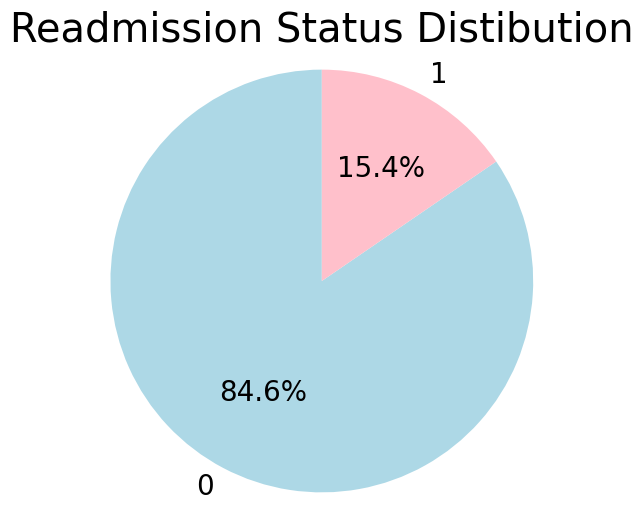

In [192]:
import matplotlib.pyplot as plt

readmission_counts = patient_label['readmission_status'].value_counts()

colors = ['lightblue', 'pink']

plt.figure(figsize=(6,6))
plt.pie(readmission_counts, labels=readmission_counts.index, autopct='%1.1f%%',
        startangle=90, colors = colors)
plt.title('Readmission Status Distibution')
plt.axis('equal')
plt.show()
